In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tsmoothie.smoother import GaussianSmoother
import spikeinterface
import spikeinterface.full as si

import helper_functions as helper
from spikeinterface.sorters import run_sorter_local

In [23]:
local_path= '/mnt/disk20tb/Organoids/Maxone/IMR90_T3_03262024_AP/IMR90_T3_03262024_AP/240326/16719/Network/000011/data.raw.h5' #network data from chip 16848
number_of_wells = 1
def get_recording_objects(local_path):
    recording_objects = []
    
    for i in range(number_of_wells):
        well_id = f'well{i:03d}'
        stream_id = f'well{i:03d}'

        recording = si.read_maxwell(local_path, stream_id=stream_id)
       
        
        channel_ids = recording.get_channel_ids()
        fs = recording.get_sampling_frequency()
        num_chan = recording.get_num_channels()
        num_seg = recording.get_num_segments()
        total_recording = recording.get_total_duration()

        print(f'Well ID: {well_id}')
        print('Sampling frequency:', fs)
        print('Number of channels:', num_chan)
        print('Number of segments:', num_seg)
        print(f"Total recording: {total_recording} s")
        print()
        recording_bp = si.bandpass_filter(recording, freq_min=300, freq_max=3000)

        recodring_cmr = si.common_reference(recording_bp, reference='global', operator='median')
        #recording_chunk = recodring_cmr.frame_slice(start_frame= 1*fs,end_frame=425*fs)
        recording_chunk = recodring_cmr.frame_slice(start_frame= 0*fs,end_frame=300*fs)
        #recording_chunk =si.scale(recording_chunk, gain=3.0)
        print(f"chunk duration: {recording_chunk.get_total_duration()} s")
        recording_objects.append(recording_chunk)
    return recording_objects

recording_objects = get_recording_objects(local_path)


Well ID: well000
Sampling frequency: 20000.0
Number of channels: 984
Number of segments: 1
Total recording: 300.08 s

chunk duration: 300.0 s


TypeError: 'Axes' object is not subscriptable

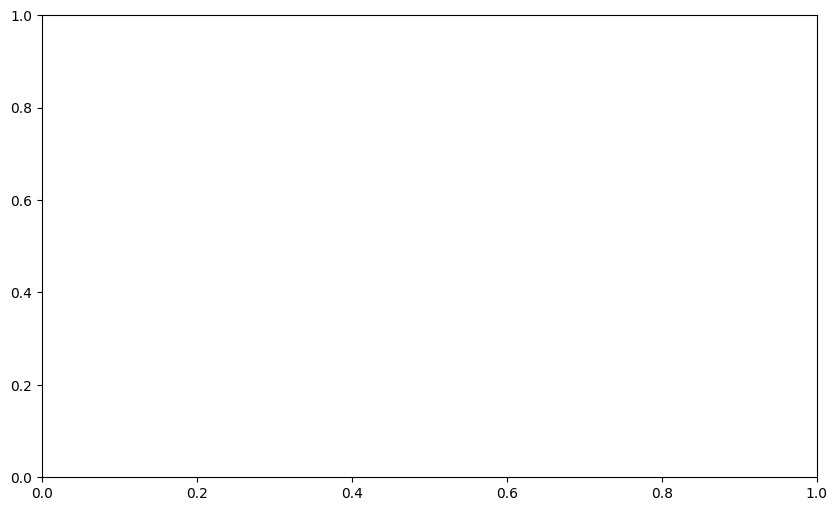

In [3]:
#BEFORE PLOTS
fig, axs = plt.subplots(len(recording_objects), figsize=(10, 6))

for i, recording in enumerate(recording_objects):
    locations = recording.get_channel_locations()
    axs[i].set_facecolor('#000000')
    for x, y in locations:
        axs[i].scatter(x, y, s=5, c='deepskyblue')
    axs[i].invert_yaxis()

plt.tight_layout()
plt.show()


#ax.set_title('Aug02 - 19388')

In [24]:
#aggregated_rec= aggregated_rec.save(fodler="./sorting/recordingtest",progress_bar=True,verbose=True)
recording_chunk = recording_objects[0]
output_folder = "./sorting/CIRM_IMR90_org_16719_KS"
docker_image= "rohanmalige/benshalom:v3"
default_KS2_params = si.get_default_sorter_params('kilosort2')
print(default_KS2_params)
#default_KS2_params['keep_good_only'] = True
default_KS2_params['detect_threshold'] = 5.5
# default_KS2_params['projection_threshold']=[18, 10]
default_KS2_params['n_jobs'] = 32
# global_job_kwargs = dict(n_jobs=32, total_memory="8G", progress_bar=True)
# si.set_global_job_kwargs(**global_job_kwargs)
run_sorter = si.run_sorter('kilosort2',recording=recording_chunk, output_folder=output_folder,docker_image= docker_image,verbose=True,remove_existing_folder=True, **default_KS2_params)

## if running on NERSC:
#run_sorter_local("kilosort2",recording_chunk, output_folder="./sorting/FolicAcid10mg", delete_output_folder=False,verbose=True,with_output=True,**default_KS2_params)
#run_sorter = ss.run_sorter('kilosort2',recording= recording_chunk, output_folder="/mnt/disk15tb/mmpatil/Spikesorting/sorter_output/kilosort2",docker_image= True,verbose=True, **default_KS2_params)

{'detect_threshold': 6, 'projection_threshold': [10, 4], 'preclust_threshold': 8, 'momentum': [20.0, 400.0], 'car': True, 'minFR': 0.1, 'minfr_goodchannels': 0.1, 'freq_min': 150, 'sigmaMask': 30, 'lam': 10.0, 'nPCs': 3, 'ntbuff': 64, 'nfilt_factor': 4, 'NT': None, 'AUCsplit': 0.9, 'wave_length': 61, 'keep_good_only': False, 'skip_kilosort_preprocessing': False, 'scaleproc': None, 'save_rez_to_mat': False, 'delete_tmp_files': ('matlab_files',), 'delete_recording_dat': False, 'n_jobs': 48, 'chunk_duration': '1s', 'progress_bar': True, 'mp_context': None, 'max_threads_per_process': 1}
installation_mode='auto' switching to installation_mode: 'github'
Starting container
Installing neo with pypi in container
Installing h5py with pypi in container
Running kilosort2 sorter inside rohanmalige/benshalom:v3
Stopping container


In [25]:
# loading the KS2 sorted object
sortingKS3 = run_sorter.remove_empty_units()
sortingKS3 = si.remove_excess_spikes(sortingKS3,recording_chunk) #Sometimes KS returns spikes outside the number of samples. < https://github.com/SpikeInterface/spikeinterface/pull/1378>

sortingKS3= sortingKS3.save(folder = output_folder+'2',overwrite=True)
#sorting_KS3 = s.Kilosort2Sorter._get_result_from_folder('./sorting/FolicAcidT2M07038_2_KS/sorter_output')
total_units = sortingKS3.get_unit_ids()
print(len(total_units))
#print(len(total_units))
channel_ids = recording_chunk.get_channel_ids()
print(channel_ids)

336
['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15'
 '16' '17' '18' '19' '20' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41' '42' '43'
 '44' '45' '46' '47' '48' '49' '50' '51' '52' '53' '54' '55' '56' '57'
 '58' '59' '60' '61' '62' '63' '64' '65' '66' '67' '68' '69' '70' '71'
 '72' '73' '74' '75' '76' '77' '78' '79' '80' '81' '82' '83' '84' '85'
 '86' '87' '88' '89' '90' '91' '92' '93' '94' '95' '96' '97' '98' '99'
 '100' '101' '102' '103' '104' '105' '106' '107' '108' '109' '110' '111'
 '112' '113' '114' '115' '116' '117' '118' '119' '120' '121' '122' '123'
 '124' '125' '126' '127' '129' '130' '131' '133' '134' '135' '137' '138'
 '139' '141' '142' '143' '145' '146' '147' '148' '149' '150' '151' '153'
 '154' '155' '157' '158' '159' '160' '161' '162' '163' '164' '165' '166'
 '167' '168' '169' '170' '171' '172' '173' '174' '175' '176' '177' '178'
 '179' '180' '181' '182' '183' '184' '185' '186' '187' '188' 

/home/mmp/.local/lib/python3.10/site-packages/spikeinterface/core/basesorting.py:239: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


In [2]:
waveform_folder = "./sorting/CIRM_IMR90_org_16719_WF"
job_kwargs = dict(n_jobs=32, chunk_duration="1s", progress_bar=True)
#waveforms = si.extract_waveforms(recording_chunk,sorting_KS3,folder="./waveformsblock1_7min",overwrite=True, ms_before=1., ms_after=2.,**job_kwargs)

#recording1.annotate(is_filtered=True)
waveforms = si.extract_waveforms(recording_chunk,sortingKS3,folder=waveform_folder,sparse=False,overwrite=True,**job_kwargs)
print(waveforms)

NameError: name 'recording_chunk' is not defined

In [7]:
import IPNAnalysis.mea_analysis_pipeline_new as mea_ap

sortingKS3 = mea_ap.get_kilosort_result('/mnt/disk15tb/mmpatil/MEA_Analysis_dev/IPNAnalysis/sorting/SPTAN1_1_16793_KS/sorter_output')
waveforms = mea_ap.get_waveforms_result('/mnt/disk15tb/mmpatil/MEA_Analysis_dev/IPNAnalysis/sorting/SPTAN1_1_16793_waveforms',sorter=sortingKS3)

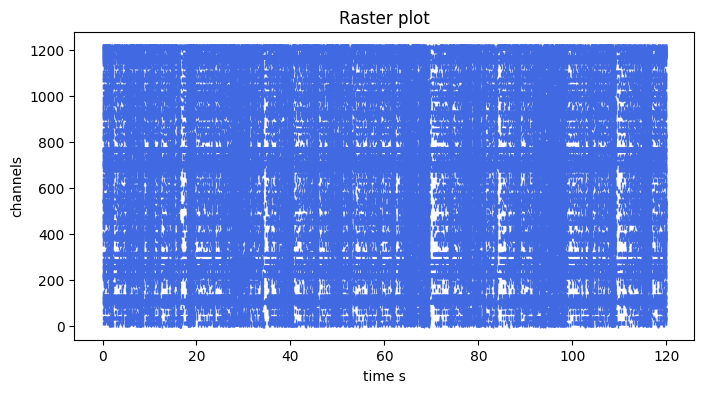

In [46]:
#extract spiketimes
fig, ax1 = plt.subplots(figsize=(8,4))
spike_times = {}
fs = 10000
for idx, unit_id in enumerate(waveforms.unit_ids):
    #print(unit_id)
    spike_train = sortingKS3.get_unit_spike_train(unit_id,start_frame=0*fs,end_frame=120*fs)
    #print(spike_train)
    if len(spike_train) > 0:
        spike_times[idx] = spike_train / float(fs)
        #print(spike_times[unit_id])
       # print(unit_id*np.ones_like(spike_times[unit_id]))
        # ax1.plot(spike_times[idx],waveforms.channel_ids_to_indices([str(int(extremum_channels_ids[unit_id]))])*np.ones_like(spike_times[idx]),
        #                      marker='|', mew=1, markersize=3,
        #                      ls='',color='royalblue')
        ax1.plot(spike_times[idx],unit_id*np.ones_like(spike_times[idx]),
                             marker='|', mew=1, markersize=3,
                             ls='',color='royalblue')
        ax1.set_title('Raster plot')
        ax1.set_xlabel('time s')
        ax1.set_ylabel("channels")

In [43]:
print(type(spike_times[1]))

<class 'numpy.ndarray'>


In [64]:
spike_times_array = np.concatenate(list(spike_times.values()))


In [65]:
import traceback


In [44]:
import elephant

isi = elephant.statistics.isi(spike_times[1])
spike_times = list(spike_times.values())
fano_factor = elephant.statistics.fanofactor(spike_times)
print(fano_factor)
print(isi)

291.21122120022864
[2.5290e-01 1.6980e-01 3.0440e-01 1.1650e-01 5.9770e-01 4.5350e-01
 1.9115e+00 2.6830e-01 1.7344e+00 9.8200e-02 2.7620e-01 2.5470e-01
 5.9700e-02 2.4400e-02 2.5600e-02 9.4400e-02 2.9900e-02 8.6600e-02
 1.9700e-02 3.9978e+00 2.0653e+00 4.6560e-01 4.7910e-01 4.6050e-01
 2.8847e+00 2.4045e+00 1.4191e+00 1.3608e+00 1.9628e+00 1.2774e+00
 6.1700e-02 1.8070e-01 7.5620e-01 5.3000e-03 1.9286e+00 9.0960e-01
 7.3260e-01 9.5300e-02 5.9360e-01 3.0170e-01 1.3070e-01 1.7800e-02
 1.0088e+00 4.0159e+00 2.9794e+00 1.2170e-01 1.4860e-01 1.7630e-01
 6.2100e-02 2.8890e-01 1.6931e+00 2.2020e-01 9.2240e-01 1.2165e+00
 3.9200e-02 8.1140e-01 4.1508e+00 1.3625e+00 1.4547e+00 1.1800e-02
 6.5790e-01 2.5970e+00 6.5600e-01 1.8116e+00 2.7954e+00 3.0330e-01
 1.2318e+00 9.8420e-01 4.4400e-02 1.2968e+00 2.5055e+00 2.4900e-02
 6.1300e-02 8.5500e-02 1.2130e-01 3.4716e+00 2.2367e+00 5.7100e-01
 1.9153e+00 3.0553e+00 1.9030e-01 1.6210e-01 1.2133e+00 8.3250e-01
 5.5860e-01 9.3400e-02 3.4757e+00 1.8260e+0

In [48]:
# spikecounts= [len(x) for x in spike_times]
# var_spikecounts = np.var(spikecounts)
# mean_spikecounts = np.mean(spikecounts)
# fanofact = var_spikecounts/mean_spikecounts
# print(fanofact)

print(np.diff(spike_times[1]))

[2.5290e-01 1.6980e-01 3.0440e-01 1.1650e-01 5.9770e-01 4.5350e-01
 1.9115e+00 2.6830e-01 1.7344e+00 9.8200e-02 2.7620e-01 2.5470e-01
 5.9700e-02 2.4400e-02 2.5600e-02 9.4400e-02 2.9900e-02 8.6600e-02
 1.9700e-02 3.9978e+00 2.0653e+00 4.6560e-01 4.7910e-01 4.6050e-01
 2.8847e+00 2.4045e+00 1.4191e+00 1.3608e+00 1.9628e+00 1.2774e+00
 6.1700e-02 1.8070e-01 7.5620e-01 5.3000e-03 1.9286e+00 9.0960e-01
 7.3260e-01 9.5300e-02 5.9360e-01 3.0170e-01 1.3070e-01 1.7800e-02
 1.0088e+00 4.0159e+00 2.9794e+00 1.2170e-01 1.4860e-01 1.7630e-01
 6.2100e-02 2.8890e-01 1.6931e+00 2.2020e-01 9.2240e-01 1.2165e+00
 3.9200e-02 8.1140e-01 4.1508e+00 1.3625e+00 1.4547e+00 1.1800e-02
 6.5790e-01 2.5970e+00 6.5600e-01 1.8116e+00 2.7954e+00 3.0330e-01
 1.2318e+00 9.8420e-01 4.4400e-02 1.2968e+00 2.5055e+00 2.4900e-02
 6.1300e-02 8.5500e-02 1.2130e-01 3.4716e+00 2.2367e+00 5.7100e-01
 1.9153e+00 3.0553e+00 1.9030e-01 1.6210e-01 1.2133e+00 8.3250e-01
 5.5860e-01 9.3400e-02 3.4757e+00 1.8260e+00 6.5700e-02 2.9470

In [ ]:
fano_factor = si.compute_firing_rates

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve, find_peaks
from scipy.stats import norm
def plot_network_activity(ax,SpikeTimes, min_peak_distance=1.0, binSize=0.1, gaussianSigma=0.16, thresholdBurst=1.2, figSize=(10, 6)):
    relativeSpikeTimes = []
    units = 0
    for unit_id, spike_times in SpikeTimes.items():
        relativeSpikeTimes.extend(spike_times) 
        units += 1 # Set the first spike time to 0
    
    relativeSpikeTimes = np.array(relativeSpikeTimes)
    relativeSpikeTimes.sort() # Convert to NumPy array

    # Step 1: Bin all spike times into small time windows
    timeVector = np.arange(min(relativeSpikeTimes), max(relativeSpikeTimes), binSize)  # Time vector for binning
    binnedTimes, _ = np.histogram(relativeSpikeTimes, bins=timeVector)  # Bin spike times
    binnedTimes = np.append(binnedTimes, 0)  # Append 0 to match MATLAB's binnedTimes length

    # Step 2: Smooth the binned spike times with a Gaussian kernel
    kernelRange = np.arange(-3*gaussianSigma, 3*gaussianSigma + binSize, binSize)  # Range for Gaussian kernel
    kernel = norm.pdf(kernelRange, 0, gaussianSigma)  # Gaussian kernel
    kernel *= binSize  # Normalize kernel by bin size
    firingRate = convolve(binnedTimes, kernel, mode='same') / binSize  # Convolve and normalize by bin size
    firingRate = firingRate / units  # Convert to Hz

    # Create a new figure with a specified size (width, height)
    #fig, ax = plt.subplots(figsize=figSize)

    # Plot the smoothed network activity
    ax.plot(timeVector, firingRate, color='royalblue')
    # Restrict the plot to the first and last 100 ms
    ax.set_xlim([min(relativeSpikeTimes), max(relativeSpikeTimes)])
    ax.set_ylim([min(firingRate)*0.8, max(firingRate)*1.2])  # Set y-axis limits to min and max of firingRate
    ax.set_ylabel('Firing Rate [Hz]')
    ax.set_xlabel('Time [ms]')
    ax.set_title('Network Activity', fontsize=11)

    # Step 3: Peak detection on the smoothed firing rate curve
    rmsFiringRate = np.sqrt(np.mean(firingRate**2))  # Calculate RMS of the firing rate

    peaks, properties = find_peaks(firingRate, prominence=1, distance=min_peak_distance)  # Find peaks above the threshold
    print(properties.keys())
    burstPeakTimes = timeVector[peaks]  # Convert peak indices to times
    #burstPeakValues = properties['prominences']  # Get the peak values
    burstPeakValues = firingRate[peaks]  # Get the peak values

        
    # Plot the threshold line and burst peaks
    #ax.plot(np.arange(timeVector[-1]), thresholdBurst * rmsFiringRate * np.ones(np.ceil(timeVector[-1]).astype(int)), color='gray')
    ax.plot(burstPeakTimes, burstPeakValues, 'or')  # Plot burst peaks as red circles    

    return fig,ax


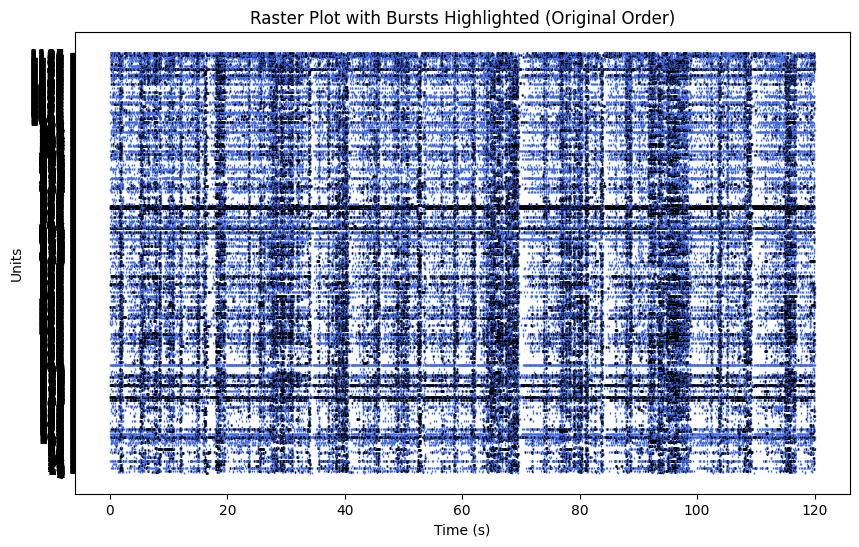

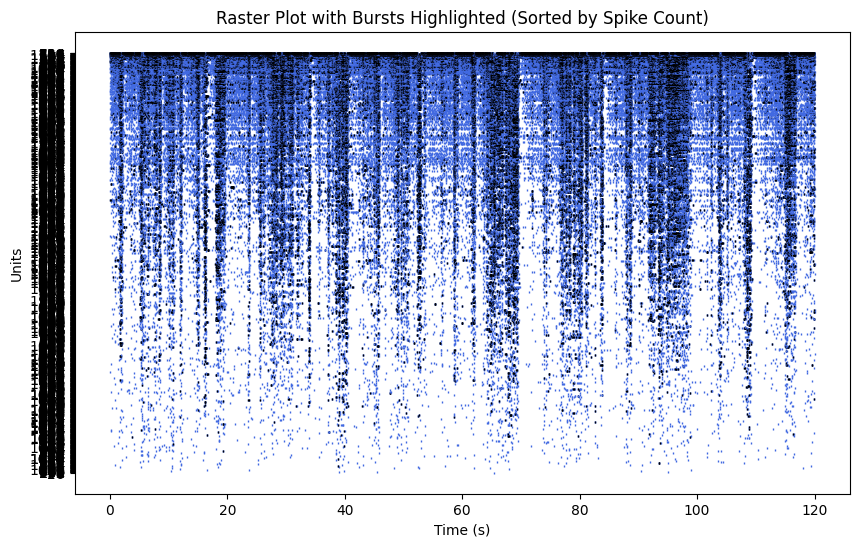

In [58]:
# Define the ISI threshold for burst detection (e.g., 0.1 seconds)
isi_threshold = 0.1

def detect_bursts(spike_times, isi_threshold):
    # Step 1: Calculate the ISIs
    isis = np.diff(spike_times)
    
    # Step 2: Identify where ISIs are below the threshold
    burst_mask = isis < isi_threshold
    
    # Step 3: Find the start and end indices of bursts
    burst_starts = np.where(np.diff(np.insert(burst_mask, 0, False).astype(int)) == 1)[0]
    burst_ends = np.where(np.diff(np.append(burst_mask, False).astype(int)) == -1)[0]
    
    # Step 4: Group spikes into bursts
    bursts = [spike_times[start:end + 1] for start, end in zip(burst_starts, burst_ends)]
    
    return bursts

# Detect bursts for each unit
bursts = {unit: detect_bursts(times, isi_threshold) for unit, times in spike_times.items()}

# Calculate spike counts for each unit
spike_counts = {unit: len(times) for unit, times in spike_times.items()}

# Sort units by ascending spike counts
sorted_units = sorted(spike_counts, key=spike_counts.get)

# Plot raster plot with bursts highlighted for all units
def plot_raster_with_bursts(ax,spike_times, bursts, sorted_units=None, title_suffix=""):
    
    
    y_offset = 0
    units_to_plot = sorted_units if sorted_units else spike_times.keys()
    
    for unit in units_to_plot:
        times = spike_times[unit]
        unit_bursts = bursts[unit]
        
        # Plot all spike times for this unit
        ax.plot(times, np.ones_like(times) + y_offset, '|', color='royalblue', markersize=1)
        
        # Highlight bursts for this unit
        for burst in unit_bursts:
            ax.plot(burst, np.ones_like(burst) + y_offset, '|', color='black', markersize=1)
        
        y_offset += 1  # Move to the next unit
    
    ax.set_xlabel('Time (s)')
    ax.set_yticks(np.arange(len(units_to_plot)) + 1)
    ax.set_yticklabels(units_to_plot)
    ax.set_ylabel('Units')
    ax.set_title(f'Raster Plot with Bursts Highlighted {title_suffix}')
    plt.show()
fig, ax = plt.subplots(figsize=(10, 6))
# Plot the original raster plot with bursts highlighted
plot_raster_with_bursts(ax,spike_times, bursts, title_suffix="(Original Order)")
fig, ax = plt.subplots(figsize=(10, 6))
# Plot the raster plot with units sorted by ascending spike counts
plot_raster_with_bursts(ax,spike_times, bursts, sorted_units=sorted_units, title_suffix="(Sorted by Spike Count)")

## NOw sorting the block scans.



In [2]:
local_path= '/mnt/disk20tb/Organoids/Maxone/IMR90_T3_03262024_AP/IMR90_T3_03262024_AP/Trace_20240328_15_57_19.raw.h5' #network data from chip 16848

def get_recording_objects(local_path):
    recording_objects = []
    
    for i in range(1):
        well_id = f'well{i:03d}'
        stream_id = f'well{i:03d}'

        recording = si.read_maxwell(local_path, stream_id=stream_id)
       
        
        channel_ids = recording.get_channel_ids()
        fs = recording.get_sampling_frequency()
        num_chan = recording.get_num_channels()
        num_seg = recording.get_num_segments()
        total_recording = recording.get_total_duration()

        print(f'Well ID: {well_id}')
        print('Sampling frequency:', fs)
        print('Number of channels:', num_chan)
        print('Number of segments:', num_seg)
        print(f"Total recording: {total_recording} s")
        print()
        recording_bp = si.bandpass_filter(recording, freq_min=300, freq_max=3000)

        recodring_cmr = si.common_reference(recording_bp, reference='global', operator='median')
        #recording_chunk = recodring_cmr.frame_slice(start_frame= 1*fs,end_frame=425*fs)
        recording_chunk = recodring_cmr.frame_slice(start_frame= 0*fs,end_frame=300*fs)
        #recording_chunk =si.scale(recording_chunk, gain=3.0)
        print(f"chunk duration: {recording_chunk.get_total_duration()} s")
        recording_objects.append(recording_chunk)
    return recording_objects

recording_objects = get_recording_objects(local_path)

Well ID: well000
Sampling frequency: 20000.0
Number of channels: 529
Number of segments: 1
Total recording: 333.39 s

chunk duration: 300.0 s


In [3]:
#aggregated_rec= aggregated_rec.save(fodler="./sorting/recordingtest",progress_bar=True,verbose=True)
recording_chunk = recording_objects[0]
output_folder = "./sorting/CIRM_org_16719_TraceBLOCK_KS"
docker_image= "rohanmalige/benshalom:v3"
default_KS2_params = si.get_default_sorter_params('kilosort2')
print(default_KS2_params)
#default_KS2_params['keep_good_only'] = True
default_KS2_params['detect_threshold'] = 5.5
# default_KS2_params['projection_threshold']=[18, 10]
default_KS2_params['n_jobs'] = 32
# global_job_kwargs = dict(n_jobs=32, total_memory="8G", progress_bar=True)
# si.set_global_job_kwargs(**global_job_kwargs)
run_sorter = si.run_sorter('kilosort2',recording=recording_chunk, output_folder=output_folder,docker_image= docker_image,verbose=True,remove_existing_folder=True, **default_KS2_params)

## if runni

{'detect_threshold': 6, 'projection_threshold': [10, 4], 'preclust_threshold': 8, 'momentum': [20.0, 400.0], 'car': True, 'minFR': 0.1, 'minfr_goodchannels': 0.1, 'freq_min': 150, 'sigmaMask': 30, 'lam': 10.0, 'nPCs': 3, 'ntbuff': 64, 'nfilt_factor': 4, 'NT': None, 'AUCsplit': 0.9, 'wave_length': 61, 'keep_good_only': False, 'skip_kilosort_preprocessing': False, 'scaleproc': None, 'save_rez_to_mat': False, 'delete_tmp_files': ('matlab_files',), 'delete_recording_dat': False, 'n_jobs': 48, 'chunk_duration': '1s', 'progress_bar': True, 'mp_context': None, 'max_threads_per_process': 1}
installation_mode='auto' switching to installation_mode: 'github'
Starting container
Installing neo with pypi in container
Installing h5py with pypi in container
Running kilosort2 sorter inside rohanmalige/benshalom:v3
Stopping container


In [4]:
# loading the KS2 sorted object
sortingKS3 = run_sorter.remove_empty_units()
sortingKS3 = si.remove_excess_spikes(sortingKS3,recording_chunk) #Sometimes KS returns spikes outside the number of samples. < https://github.com/SpikeInterface/spikeinterface/pull/1378>

sortingKS3= sortingKS3.save(folder = output_folder+'2',overwrite=True)
#sorting_KS3 = s.Kilosort2Sorter._get_result_from_folder('./sorting/FolicAcidT2M07038_2_KS/sorter_output')
total_units = sortingKS3.get_unit_ids()
print(len(total_units))
#print(len(total_units))
channel_ids = recording_chunk.get_channel_ids()
print(channel_ids)

72
['1' '3' '5' '7' '9' '11' '13' '15' '17' '19' '21' '23' '25' '27' '29'
 '31' '33' '35' '37' '39' '41' '43' '45' '47' '49' '51' '53' '55' '57'
 '59' '61' '63' '65' '67' '69' '71' '73' '75' '77' '79' '81' '83' '85'
 '87' '89' '91' '93' '95' '97' '99' '101' '103' '105' '107' '109' '111'
 '113' '115' '117' '119' '121' '123' '125' '127' '129' '131' '133' '135'
 '137' '139' '141' '143' '145' '147' '149' '151' '153' '155' '157' '159'
 '161' '163' '165' '167' '169' '171' '173' '175' '177' '179' '181' '183'
 '185' '187' '189' '191' '193' '195' '197' '199' '201' '203' '205' '207'
 '209' '211' '213' '215' '217' '219' '221' '223' '225' '227' '229' '231'
 '233' '235' '237' '239' '241' '243' '245' '247' '249' '251' '253' '255'
 '257' '259' '261' '263' '265' '267' '269' '273' '275' '277' '281' '283'
 '285' '289' '293' '295' '297' '301' '305' '309' '313' '317' '321' '325'
 '329' '333' '337' '341' '345' '349' '353' '357' '365' '369' '373' '377'
 '381' '385' '389' '393' '395' '397' '401' '405' '409' 

/home/mmp/.local/lib/python3.10/site-packages/spikeinterface/core/basesorting.py:239: UserWarning: The registered recording will not be persistent on disk, but only available in memory
  warnings.warn("The registered recording will not be persistent on disk, but only available in memory")


In [5]:
waveform_folder = "./sorting/CIRM_16719_traceblock_WF"
job_kwargs = dict(n_jobs=32, chunk_duration="1s", progress_bar=True)
#waveforms = si.extract_waveforms(recording_chunk,sorting_KS3,folder="./waveformsblock1_7min",overwrite=True, ms_before=1., ms_after=2.,**job_kwargs)

#recording1.annotate(is_filtered=True)
waveforms = si.extract_waveforms(recording_chunk,sortingKS3,folder=waveform_folder,sparse=False,overwrite=True,**job_kwargs)
print(waveforms)

extract waveforms memmap multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

WaveformExtractor: 529 channels - 72 units - 1 segments
  before:20 after:40 n_per_units:500


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

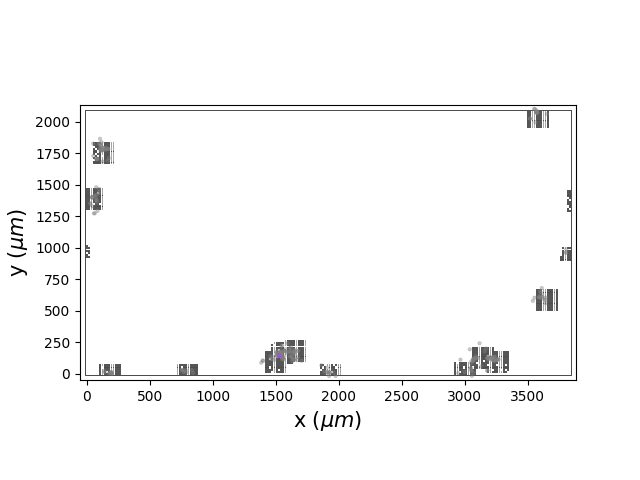

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

In [ ]:
%matplotlib widget
#waveforms=si.compute_unit_locations(waveforms)
waveforms=si.load_waveforms(waveform_folder)


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

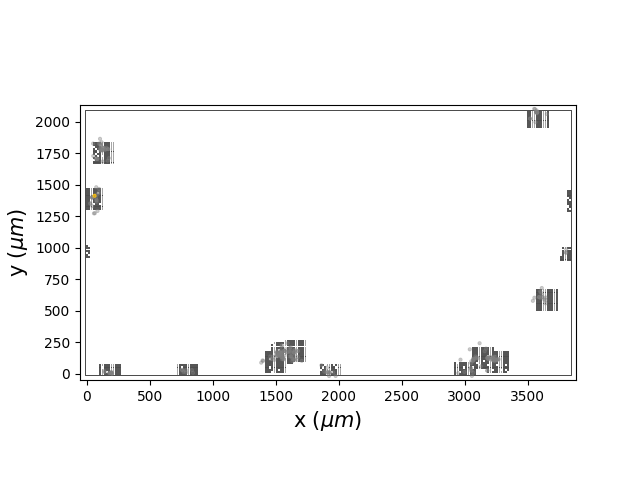

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


In [ ]:
si.plot_unit_locations(waveforms,with_channel_ids=False,unit_ids=[10])

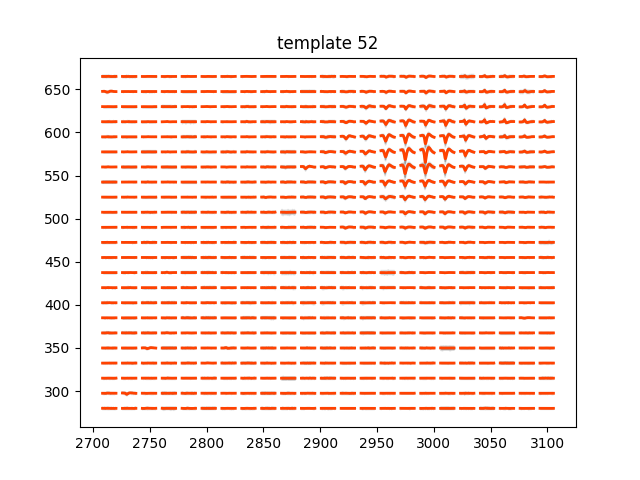

In [11]:
si.plot_unit_templates(waveforms,unit_ids=[52])

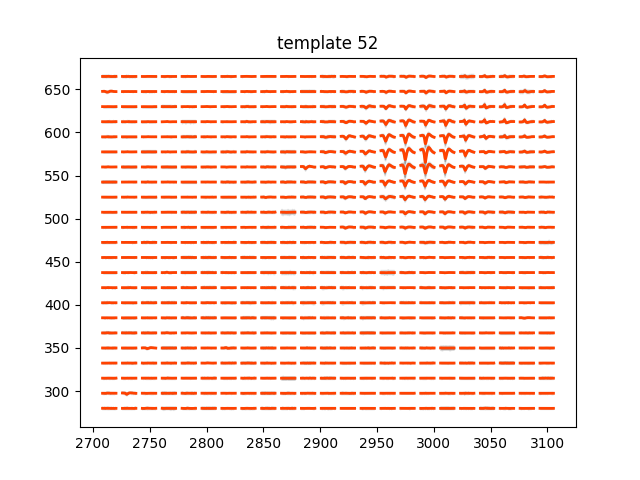

In [21]:
%matplotlib widget
objs = si.plot_unit_templates(waveforms,unit_ids=[52])

In [20]:
objs.figure.savefig('/home/mmp/Documents/CIRM_25MAR/oragnoid_16719_traceblock/traceblock_unit52.svg', dpi=300, format='svg')

In [118]:
locations = si.compute_unit_locations(waveforms)
unit_locations =dict(zip(waveforms.unit_ids,locations))
print(unit_locations)


{0: array([3234.58652715,  115.59166649,   33.80241638]), 1: array([3575.8066484 , 2074.86152814,    9.55601934]), 2: array([3572.28788922, 2075.35697418,   26.18716493]), 3: array([196.22250643,   4.91911575,  22.63225794]), 4: array([3572.39845559, 2075.90866035,   16.37716584]), 5: array([193.73990845,   5.76567323,   8.57426544]), 6: array([3575.82698681, 2076.66349557,   11.48218541]), 7: array([  52.8740453 , 1727.80941679,  117.6937249 ]), 8: array([7.99198849e+01, 1.41812913e+03, 1.00000000e+00]), 9: array([9.68735708e+01, 1.43956104e+03, 1.00000000e+00]), 10: array([  63.04893523, 1411.43108267,    2.72875719]), 11: array([2.85667187e+01, 1.35142292e+03, 1.18363944e+00]), 12: array([3807.89996137,  986.04874507,    4.32255336]), 13: array([7.90988034e+01, 1.37579530e+03, 1.00000000e+00]), 14: array([  44.66663004, 1329.12305845,    3.07340429]), 15: array([3617.07802306,  607.87509877,   21.92846115]), 16: array([3591.83608843,  606.74457964,   18.79766849]), 17: array([  65.1

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

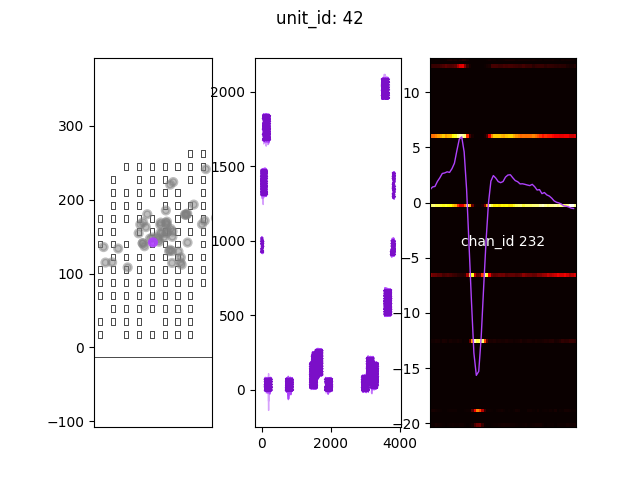

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

In [ ]:
si.plot_unit_summary(waveforms,unit_id=42)

In [6]:
extremum_channels_ids =si.get_template_extremum_channel(waveforms,peak_sign ='neg',mode='at_index')
for i, unit_id in enumerate(waveforms.unit_ids):
    fig, ax = plt.subplots()
    
    wf = waveforms.get_waveforms(unit_id)
    #print(wf.shape)
    #print(int(extremum_channels[unit_id]))
    channel_id_str = str(int(extremum_channels_ids[unit_id]))
    number = waveforms.channel_ids_to_indices([channel_id_str])
    #number =[539]
    #print(number)
    ax.plot(wf[:,:, number[0]].T,  lw=1, color='black', alpha=0.1, linestyle='-', marker='', markersize=0)
    ax.set_title(f"waveforms of a putative neuron")
    ax.set_ylabel("Amplitude (µV)")
    ax.set_xlabel("Sampled timepoints (5e-2 ms)")
    ax.set_facecolor('white')  # Set the background color to black

    # Customize the appearance of tick labels and axes
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    # ax.spines['bottom'].set_color('white')
    ax.spines['top'].set_color('white')
    ax.spines['right'].set_color('white')
    # ax.spines['left'].set_color('white')
    
    plt.savefig(f'/home/mmp/Documents/CIRM_25MAR/oragnoid_16719_traceblock/waveforms/waveforms_unit_id_{unit_id}__channel_id_{channel_id_str}_channel_index_{number[0]}.svg', format='svg',dpi=300)
    plt.close(fig)

In [65]:
extremum_channels_ids

{0: '561',
 1: '744',
 2: '486',
 3: '486',
 4: '2',
 5: '744',
 6: '112',
 7: '127',
 8: '438',
 9: '246',
 10: '438',
 11: '10',
 12: '17',
 13: '562',
 14: '618',
 15: '75',
 16: '77',
 17: '106',
 18: '940',
 19: '660',
 20: '305',
 21: '117',
 22: '117',
 23: '120',
 24: '124',
 25: '125',
 26: '486',
 27: '638',
 28: '142',
 29: '632',
 30: '174',
 31: '206',
 32: '178',
 33: '183',
 34: '462',
 35: '462',
 36: '202',
 37: '202',
 38: '202',
 39: '206',
 40: '210',
 41: '216',
 42: '232',
 43: '234',
 44: '292',
 45: '257',
 46: '638',
 47: '275',
 48: '555',
 49: '53',
 51: '290',
 52: '487',
 54: '326',
 55: '338',
 56: '341',
 57: '341',
 58: '206',
 59: '529',
 60: '356',
 61: '290',
 62: '290',
 63: '371',
 64: '372',
 65: '376',
 66: '154',
 67: '400',
 68: '719',
 69: '422',
 70: '343',
 71: '343',
 72: '329',
 73: '379',
 74: '437',
 75: '10',
 76: '449',
 77: '452',
 78: '258',
 79: '356',
 80: '188',
 81: '429',
 82: '476',
 83: '626',
 84: '510',
 85: '525',
 86: '528'

In [66]:
channel_ids = recording_chunk.get_channel_ids()

# Specify the particular channel ID you are interested in
specific_channel_id = '232' # Replace `desired_channel_id` with the actual ID you're looking for

index = np.where(np.array(channel_ids) == specific_channel_id)[0][0]
index

232

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

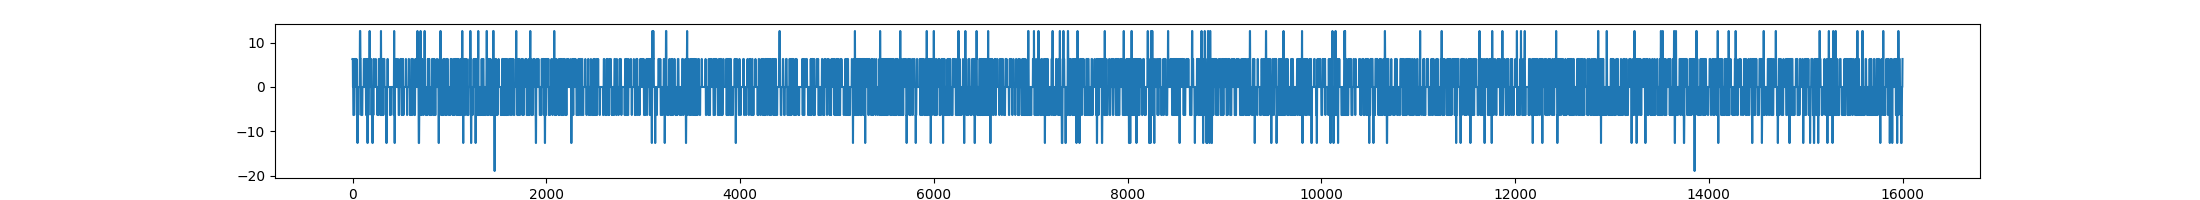

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

In [ ]:
traces = recording.get_traces(start_frame=172550, end_frame=188550, segment_index=0,return_scaled=True)
plt.figure(figsize=(22,2))                                                                                                                                                                                                                                                              
plt.plot(traces[:,232])

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

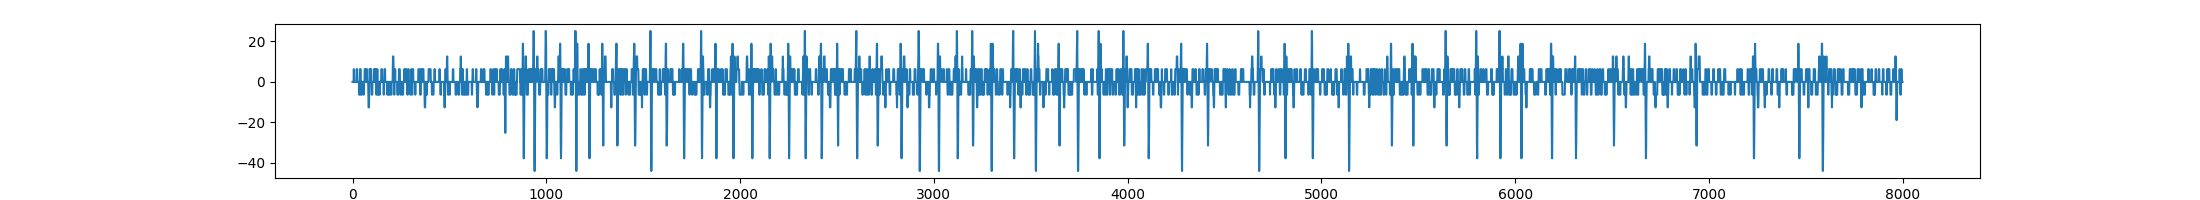

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


In [131]:
traces = recording_chunk.get_traces(start_frame=493550, end_frame=501550, segment_index=0,return_scaled=True)
plt.figure(figsize=(22,2))                                                                                                                                                                                                                                                              
plt.plot(traces[:,304])
plt.savefig('/home/mmp/Documents/CIRM_25MAR/oragnoid_16719/trace_unit20.svg', format='svg',dpi=300)